# EX9) Color Quantization using K-Means
- Kmeans 활용 색상 양자화

In [1]:
from time import time

import matplotlib.pyplot as plt
import numpy as np

from sklearn.cluster import KMeans
from sklearn.datasets import load_sample_image
from sklearn.metrics import pairwise_distances_argmin
from sklearn.utils import shuffle

n_colors = 64

In [2]:
china = load_sample_image('china.jpg')

china = np.array(china, dtype=np.float64) / 255

w, h, d = original_shape = tuple(china.shape)
assert d == 3
image_array = np.reshape(china, (w*h, d))

In [3]:
print('Fitting model on a small sub-sample of the data')
t0 = time()
image_array_sample = shuffle(image_array, random_state=0, n_samples=1_000)
kmeans = KMeans(n_clusters=n_colors, n_init='auto', random_state=0).fit(
    image_array_sample
)
print(f'done in {time() - t0:0.3f}s.')

Fitting model on a small sub-sample of the data
done in 0.045s.


In [4]:
codebook_random = shuffle(image_array, random_state=0, n_samples=n_colors)
print('Predicting color indices on the full image (k-means)')
t0 = time()
labels = kmeans.predict(image_array)
print(f"done in {time() - t0:0.3f}s.")

Predicting color indices on the full image (k-means)
done in 0.007s.


In [5]:
codebook_random = shuffle(image_array, random_state=0, n_samples=n_colors)
print('Predicting color indices on the full image (random)')
t0 = time()
labels_random = pairwise_distances_argmin(codebook_random, image_array, axis=0)
print(f'done in {time() - t0:.3f}s.')

Predicting color indices on the full image (random)
done in 0.013s.


In [6]:
def recreate_image(codebook, labels, w, h):
    return codebook[labels].reshape(w, h, -1)

def show_image(title, image):
    fig = plt.figure(1)
    fig.clf()
    plt.axis('off')
    plt.title(title)
    plt.imshow(image)
    plt.close()

    return fig

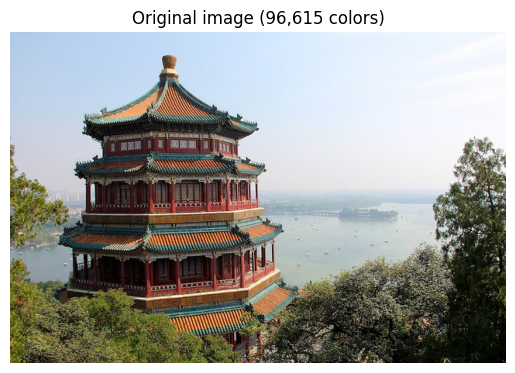

In [7]:
show_image('Original image (96,615 colors)', china)

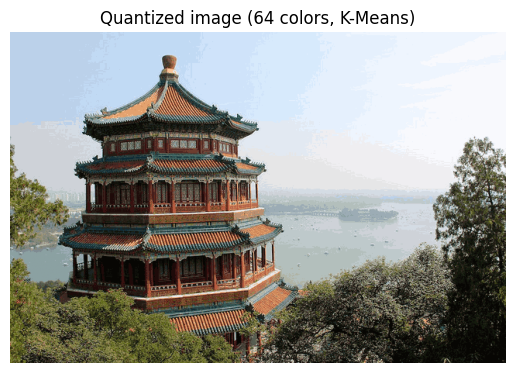

In [8]:
show_image(f'Quantized image ({n_colors} colors, K-Means)', recreate_image(kmeans.cluster_centers_, labels, w, h))

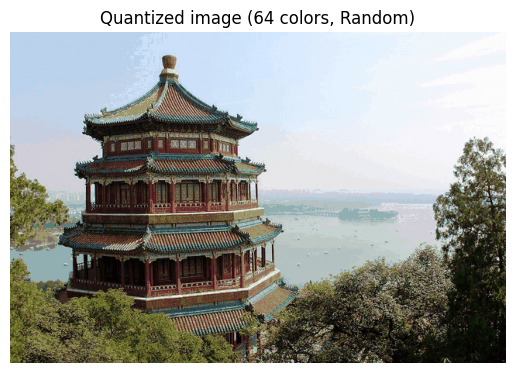

In [9]:
show_image(f'Quantized image ({n_colors} colors, Random)', recreate_image(codebook_random, labels_random, w, h))

# EX10) Compare BIRCH and MiniBatchKMeans

- 많은 양의 데이터 k-means

In [10]:
from itertools import cycle
from time import time

import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
from joblib import cpu_count

from sklearn.cluster import Birch, MiniBatchKMeans
from sklearn.datasets import make_blobs

In [11]:
# center 만들기 (10 * 10 그리드)
xx = np.linspace(-22, 22, 10)
yy = np.linspace(-22, 22, 10)
xx, yy = np.meshgrid(xx, yy)
n_centers = np.hstack((np.ravel(xx)[:, np.newaxis], np.ravel(yy)[:, np.newaxis]))

X, y = make_blobs(n_samples=25_000, centers=n_centers, random_state=0)
colors_ = cycle(colors.cnames.keys())

BIRCH without global clustering as the final step took 0.29 seconds
n_clusters : 158
BIRCH with global clustering as the final step took 0.28 seconds
n_clusters : 100
Time taken to run MiniBatchKMeans 0.26 seconds


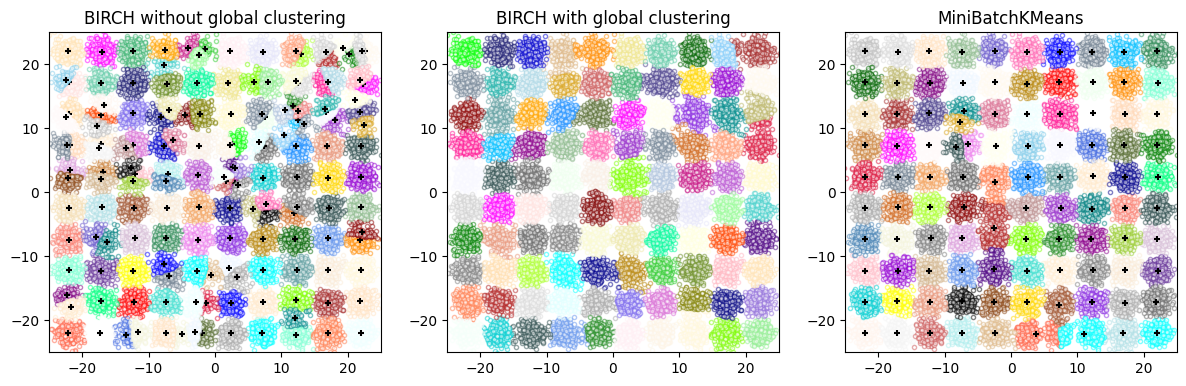

In [12]:
fig = plt.figure(figsize=(12, 4))
fig.subplots_adjust(left=0.04, right=0.98, bottom=0.1, top=0.9)

birch_models = [
    Birch(threshold=1.7, n_clusters=None),
    Birch(threshold=1.7, n_clusters=100)
]
final_step = ['without global clustering', 'with global clustering']

for ind, (birch_models, info) in enumerate(zip(birch_models, final_step)):
    t = time()
    birch_models.fit(X)
    print(f'BIRCH {info} as the final step took {time() - t:.2f} seconds')

    labels = birch_models.labels_
    centroids = birch_models.subcluster_centers_
    n_clusters = np.unique(labels).size
    print(f'n_clusters : {n_clusters}')

    ax = fig.add_subplot(1, 3, ind+1)
    for this_centroid, k, col in zip(centroids, range(n_clusters), colors_):
        mask = labels == k
        ax.scatter(X[mask, 0], X[mask, 1], c='w', edgecolors=col, marker='.', alpha=0.5)
        if birch_models.n_clusters is None:
            ax.scatter(this_centroid[0], this_centroid[1], marker='+', c='k', s=25)
    ax.set_ylim([-25, 25])
    ax.set_xlim([-25, 25])
    ax.set_autoscaley_on(False)
    ax.set_title('BIRCH %s' % info)

mbk = MiniBatchKMeans(
    init='k-means++',
    n_clusters=100,
    batch_size=256 * cpu_count(),
    n_init=10,
    max_no_improvement=10,
    verbose=0,
    random_state=0,
)
t0 = time()
mbk.fit(X)
t_mini_batch = time() - t0
print('Time taken to run MiniBatchKMeans %0.2f seconds' % t_mini_batch)
mbk_means_labels_unique = np.unique(mbk.labels_)

ax = fig.add_subplot(1, 3, 3)
for this_centroid, k, col in zip(mbk.cluster_centers_, range(n_clusters), colors_):
    mask = mbk.labels_ == k
    ax.scatter(X[mask, 0], X[mask, 1], marker='.', c='w', edgecolor=col, alpha=0.5)
    ax.scatter(this_centroid[0], this_centroid[1], marker='+', c='k', s=25)
ax.set_xlim([-25, 25])
ax.set_ylim([-25, 25])
ax.set_title('MiniBatchKMeans')
ax.set_autoscaley_on(False)
plt.show()

- 속도가 더 빠르진 않네...?

# EX11) Comparing different clustering algorithms on toy dataset

- 여러 클러스터링 방법을 비교

In [13]:
from time import time
import warnings
from itertools import cycle, islice

import matplotlib.pyplot as plt
import numpy as np

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler

In [14]:
# 데이터 셋 만들기
n_samples = 500
seed = 30
noisy_circles = datasets.make_circles(
    n_samples=n_samples, factor=0.5, noise=0.05, random_state=seed
)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=0.05, random_state=seed)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=seed)
rng = np.random.RandomState(seed)
no_structure = rng.rand(n_samples, 2), None

random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

varied = datasets.make_blobs(
    n_samples=n_samples, cluster_std=[1.0, 2.5, 0.5], random_state=random_state
)

In [15]:
plot_num = 1

default_base = {
    'quantile': 0.3,
    'eps': 0.3,
    'damping': 0.9,
    'preference': -200,
    'n_neighbors': 3,
    'n_clusters': 3,
    'min_samples': 7,
    'xi': 0.05,
    'min_cluster_size': 0.1,
    'allow_single_cluster': True,
    'hdbscan_min_cluster_size': 15,
    'hdbscan_min_samples': 3,
    'random_state': 42,
}

datasets = [
    (
        noisy_circles,
        {
            'damping': 0.77,
            'preference': -240,
            'quantile': 0.2,
            'n_clusters': 2,
            'min_samples': 7,
            'xi': 0.08,
        },
    ),
    (
        noisy_moons,
        {
            'damping': 0.75,
            'preference': -220,
            'n_clusters': 2,
            'min_samples': 7,
            'xi': 0.1,
        },
    ),
    (
        varied,
        {
            'eps': 0.18,
            'n_neighbors': 2,
            'min_samples': 7,
            'xi': 0.01,
            'min_cluster_size': 0.2,
        },
    ),
    (
        aniso,
        {
            'eps': 0.15,
            'n_neighbors': 2,
            'min_samples': 7,
            'xi': 0.1,
            'min_cluster_size': 0.2,
        },
    ),
    (blobs, {'min_samples': 7, 'xi': 0.1, 'min_cluster_size': 0.2}),
    (no_structure, {}),
]

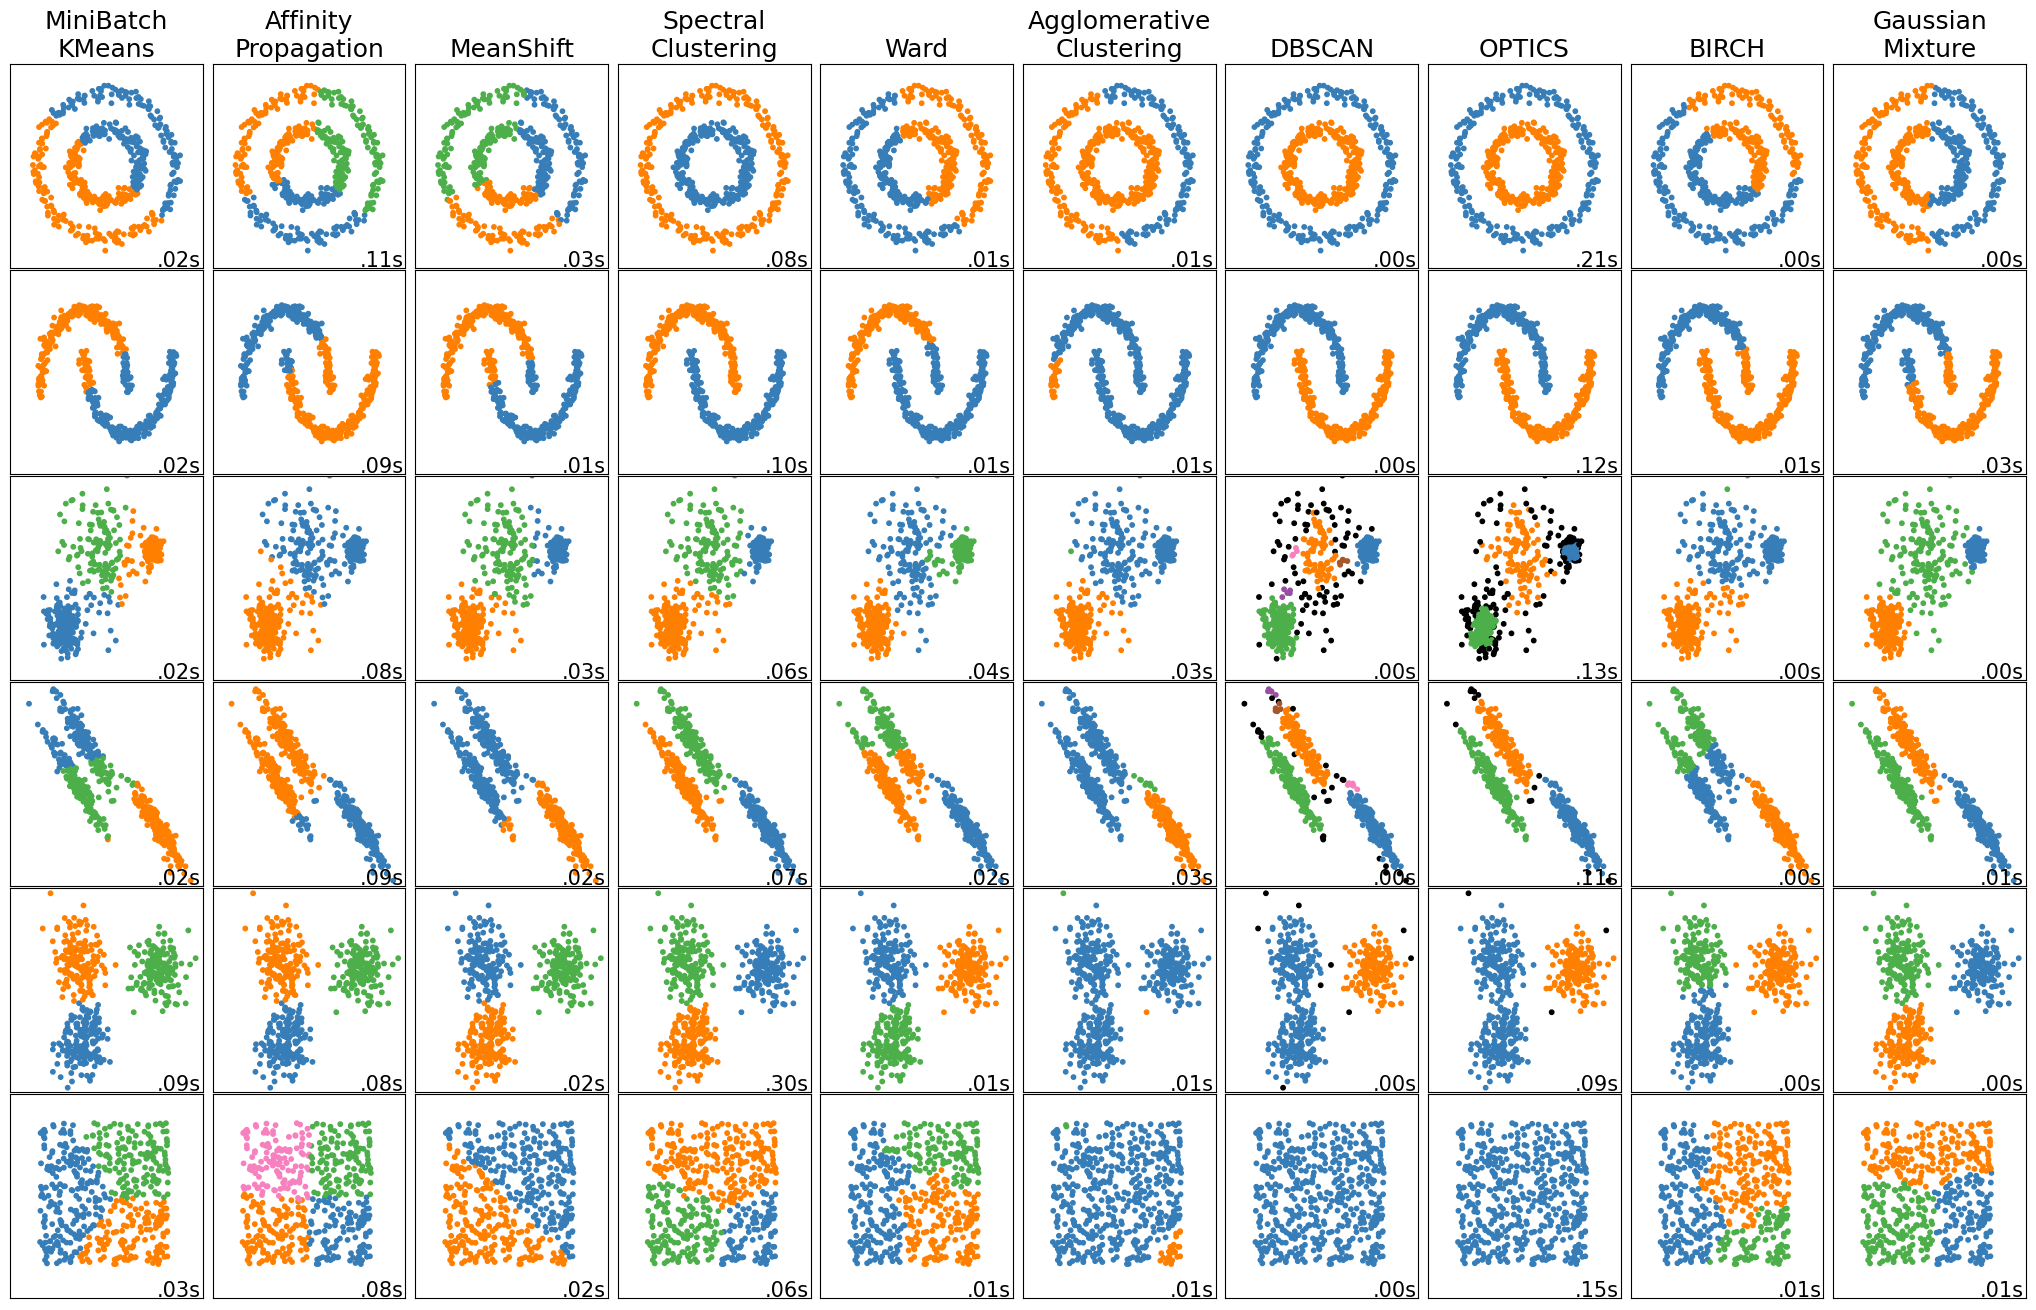

In [16]:
plt.figure(figsize=(9 * 2 + 3, 13))
plt.subplots_adjust(
    left=0.02, right=0.98, bottom=0.001, top=0.95, wspace=0.05, hspace=0.01
)

for i_dataset, (dataset, algo_params) in enumerate(datasets):
    params = default_base.copy()
    params.update(algo_params)

    X, y = dataset

    X = StandardScaler().fit_transform(X)

    bandwidth = cluster.estimate_bandwidth(X, quantile=params['quantile'])
    connectivity = kneighbors_graph(
        X, n_neighbors=params["n_neighbors"], include_self=False
    )
    connectivity = 0.5 * (connectivity + connectivity.T)

    ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
    two_means = cluster.MiniBatchKMeans(
        n_clusters=params['n_clusters'],
        n_init='auto',
        random_state=params['random_state'],
    )
    ward = cluster.AgglomerativeClustering(
        n_clusters=params['n_clusters'], linkage='ward', connectivity=connectivity
    )
    spectral = cluster.SpectralClustering(
        n_clusters=params['n_clusters'],
        eigen_solver='arpack',
        affinity='nearest_neighbors',
        random_state=params['random_state'],
    )
    dbscan = cluster.DBSCAN(eps=params['eps'])
    # hdbscan = cluster.HDBSCAN(
    #     min_samples=params['hdbscan_min_samples'],
    #     min_cluster_size=params['hdbscan_min_cluster_size'],
    #     allow_single_cluster=params['allow_single_cluster'],
    # )
    optics = cluster.OPTICS(
        min_samples=params['min_samples'],
        xi=params['xi'],
        min_cluster_size=params['min_cluster_size'],
    )
    affinity_propagation = cluster.AffinityPropagation(
        damping=params['damping'],
        preference=params['preference'],
        random_state=params['random_state'],
    )
    average_linkage = cluster.AgglomerativeClustering(
        linkage='average',
        metric='cityblock',
        n_clusters=params['n_clusters'],
        connectivity=connectivity,
    )
    birch = cluster.Birch(n_clusters=params['n_clusters'])
    gmm = mixture.GaussianMixture(
        n_components=params['n_clusters'],
        covariance_type='full',
        random_state=params['random_state'],
    )

    clustering_algorithms = (
        ('MiniBatch\nKMeans', two_means),
        ('Affinity\nPropagation', affinity_propagation),
        ('MeanShift', ms),
        ('Spectral\nClustering', spectral),
        ('Ward', ward),
        ('Agglomerative\nClustering', average_linkage),
        ('DBSCAN', dbscan),
        # ('HDBSCAN', hdbscan),
        ('OPTICS', optics),
        ('BIRCH', birch),
        ('Gaussian\nMixture', gmm),
    )

    for name, algorithm in clustering_algorithms:
        t0 = time()
        with warnings.catch_warnings():
            warnings.filterwarnings(
                'ignore',
                message='the number of connected components of the '
                + 'connectivity matrix is [0-9]{1,2}'
                + ' > 1. Completing it to avoid stopping the tree early.',
                category=UserWarning,
            )
            warnings.filterwarnings(
                'ignore',
                message='Graph is not fully connected, spectral embedding'
                + ' may not work as expected.',
                category=UserWarning,
            )
            algorithm.fit(X)

        t1 = time()
        if hasattr(algorithm, 'labels_'):
            y_pred = algorithm.labels_.astype(int)
        else:
            y_pred = algorithm.predict(X)

        plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)

        colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a', '#f781bf', '#a65628', '#984ea3', '#999999', '#e41a1c', '#dede00']),
                    int(max(y_pred) + 1),
                )
            )
        )
        colors = np.append(colors, ['#000000'])
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plt.text(
            0.99,
            0.01,
            ('%.2fs' % (t1 - t0)).lstrip('0'),
            transform=plt.gca().transAxes,
            size=15,
            horizontalalignment='right',
        )
        plot_num += 1

plt.show()

# EX12) Comparing different hierachical linkage methods on toy datasets


In [17]:
from time import time
import warnings
from itertools import cycle, islice

import matplotlib.pyplot as plt
import numpy as np

from sklearn import cluster, datasets
from sklearn.preprocessing import StandardScaler

In [18]:
n_samples = 1500
noisy_circles = datasets.make_circles(
    n_samples=n_samples, factor=0.5, noise=0.05, random_state=170
)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=0.05, random_state=170)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=170)
rng = np.random.RandomState(170)
no_structure = rng.rand(n_samples, 2), None

X, y = datasets.make_blobs(n_samples=n_samples, random_state=170)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

varied = datasets.make_blobs(
    n_samples=n_samples, cluster_std=[1.0, 2.5, 0.5], random_state=170
)

plot_num = 1

default_base = {"n_neighbors": 10, "n_clusters": 3}

datasets = [
    (noisy_circles, {"n_clusters": 2}),
    (noisy_moons, {"n_clusters": 2}),
    (varied, {"n_neighbors": 2}),
    (aniso, {"n_neighbors": 2}),
    (blobs, {}),
    (no_structure, {}),
]

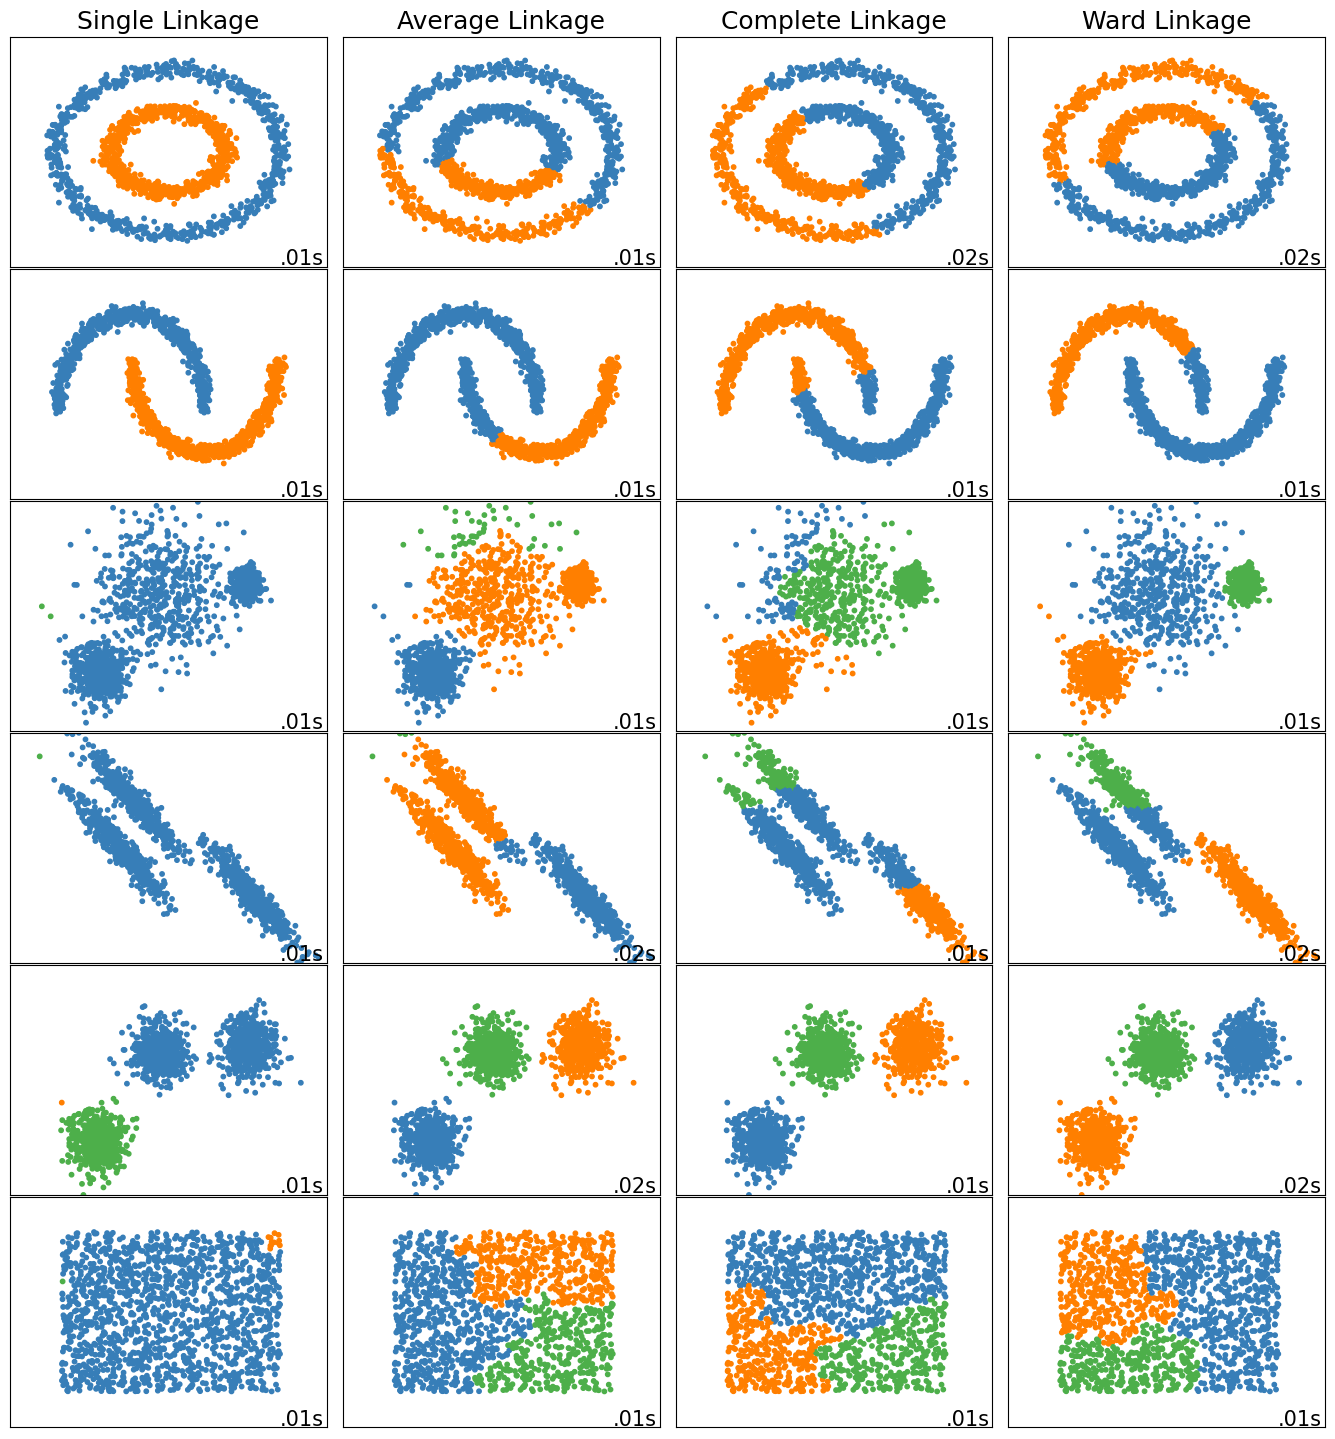

In [19]:
plt.figure(figsize=(9 * 1.3 + 2, 14.5))
plt.subplots_adjust(
    left=0.02, right=0.98, bottom=0.001, top=0.96, wspace=0.05, hspace=0.01
)

for i_dataset, (dataset, algo_params) in enumerate(datasets):
    params = default_base.copy()
    params.update(algo_params)

    X, y = dataset
    X = StandardScaler().fit_transform(X)

    ward = cluster.AgglomerativeClustering(
        n_clusters=params['n_clusters'], linkage='ward'
    )
    complete = cluster.AgglomerativeClustering(
        n_clusters=params['n_clusters'], linkage='complete'
    )
    average = cluster.AgglomerativeClustering(
        n_clusters=params['n_clusters'], linkage='average'
    )
    single = cluster.AgglomerativeClustering(
        n_clusters=params['n_clusters'], linkage='single'
    )

    clustering_algorithms = (
        ('Single Linkage', single),
        ('Average Linkage', average),
        ('Complete Linkage', complete),
        ('Ward Linkage', ward),
    )

    for name, algorithm in clustering_algorithms:
        t0 = time()
        with warnings.catch_warnings():
            warnings.filterwarnings(
                'ignore',
                message='the number of connected components of the '
                + 'connectivity matrix is [0-9]{1,2}'
                + ' > 1. Completing it to avoid stopping the tree early.',
                category=UserWarning,
            )
            algorithm.fit(X)

        t1 = time()
        if hasattr(algorithm, 'labels_'):
            y_pred = algorithm.labels_.astype(int)
        else:
            y_pred = algorithm.predict(X)

        plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)

        colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a', '#f781bf', '#a65628', '#984ea3', '#999999', '#e41a1c', '#dede00']),
                    int(max(y_pred) + 1),
                )
            )
        )
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plt.text(
            0.99,
            0.01,
            ('%.2fs' % (t1 - t0)).lstrip('0'),
            transform=plt.gca().transAxes,
            size=15,
            horizontalalignment='right',
        )
        plot_num += 1

plt.show()
